In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import Tensor

from train import ModelManager, DIR_ROOT_SAVE, DIR_ROOT_LOG
from utils import get_loader, get_cifar100

# globals
NUM_CLASSES = 100
BATCH_SIZE = 25
NUM_TRAIN = 50000
NUM_TEST = 10000
EPOCHS = 60

NOTEBOOK_NAME = 'prune_10_70_p'
PATH_EL2N = os.path.join(DIR_ROOT_SAVE, 'el2n', 'general.pt')
PATH_FORGET = os.path.join(DIR_ROOT_SAVE, 'flip_cifar100', 'model', 'other.pt')
PATH_LOG = os.path.join(DIR_ROOT_LOG, NOTEBOOK_NAME, 'test_acc.pt')

print('train on:', ModelManager.DEVICE)

train_idx = np.arange(NUM_TRAIN, dtype=int)
test_idx = np.arange(NUM_TEST, dtype=int)
dataset_train, dataset_test, dataset_train_for_test, dataset_train_raw = get_cifar100()
loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, shuffle=True)
loader_test = get_loader(dataset_test, test_idx, BATCH_SIZE, shuffle=False)
loader_train_ordered = get_loader(dataset_train_for_test, train_idx, BATCH_SIZE, shuffle=False)
Y_train = Tensor(dataset_train.targets)[train_idx].type(torch.int64)
Y_test = Tensor(dataset_test.targets)[test_idx].type(torch.int64)

# get prune scores
data = torch.load(PATH_EL2N)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']
change_counter = torch.load(PATH_FORGET)['change_counter']
true_forget = torch.load(PATH_FORGET)['true_forget']
km = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar100_512', 'km_dist.npy'))
km100 = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar100_512', 'km_dist_100.npy'))
km200 = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar100_512', 'km_dist_200.npy'))

# forgetting_model = ModelManager(NUM_CLASSES, 'forgetting', load=True)
# change_counter = forgetting_model.data_other['change_counter']

# ensemble_softmax = torch.arange(NUM_TRAIN)
# ensemble_pred = torch.arange(NUM_TRAIN)
# ensemble_pred_sum = torch.arange(NUM_TRAIN)
# # ensemble_std =  torch.arange(NUM_TRAIN)
# el2n_scores = torch.arange(NUM_TRAIN)
# change_counter = torch.arange(NUM_TRAIN)

idx_sorted_el2n = el2n_scores.sort()[1].numpy()
idx_sorted_forgetting = change_counter.sort()[1].numpy()
idx_sorted_std = ensemble_std.sum(dim=1).sort()[1].numpy()
idx_sorted_pred_sum = ensemble_pred_sum.sort()[1].numpy()[::-1]
idx_random_prune = np.random.choice(np.arange(NUM_TRAIN), NUM_TRAIN, replace=False)
idx_true_forget = true_forget.sort()[1].numpy()
idx_sorted_km = np.argsort(km)
idx_sorted_km100 = np.argsort(km100)
idx_sorted_km200 = np.argsort(km200)

idx_sorted = {'random': idx_random_prune, 'el2n': idx_sorted_el2n, 'std': idx_sorted_std,
              'pred_sum': idx_sorted_pred_sum, 'forget': idx_sorted_forgetting, 'true_forget': idx_true_forget,
              'km': idx_sorted_km, 'km100': idx_sorted_km100, 'km200': idx_sorted_km200}

data = pd.DataFrame({
    'EL2N': el2n_scores.numpy(),
    'Std': ensemble_std.sum(dim=1).numpy(),
    'True p sum': ensemble_pred_sum.numpy(),  # number of models that right on each example
    'Forget': change_counter.numpy(),
    'true_forget': true_forget.numpy(),
    'km': km,
    'km100': km100,
    'km200': km200
})
data.corr()

train on: cuda
Files already downloaded and verified
Files already downloaded and verified


,EL2N,Std,True p sum,Forget,true_forget,km,km100,km200
EL2N,1.000000,0.763640,-0.931154,0.631182,0.015292,0.299591,0.364110,0.382782
Std,0.763640,1.000000,-0.653038,0.667967,0.121611,0.384026,0.440735,0.461708
True p sum,-0.931154,-0.653038,1.000000,-0.544786,0.114446,-0.250940,-0.299588,-0.316367
Forget,0.631182,0.667967,-0.544786,1.000000,0.394457,0.306184,0.355912,0.370274
true_forget,0.015292,0.121611,0.114446,0.394457,1.000000,0.006370,0.025260,0.031864
km,0.299591,0.384026,-0.250940,0.306184,0.006370,1.000000,0.805662,0.737580
km100,0.364110,0.440735,-0.299588,0.355912,0.025260,0.805662,1.000000,0.841076
km200,0.382782,0.461708,-0.316367,0.370274,0.031864,0.737580,0.841076,1.000000


In [2]:
no_prune = ModelManager(NUM_CLASSES, model_name='no_prune', dir_='prune_25p', load=True)
prune_sizes = [.1, .2, .25, .3, .4, .5, .6, .7]
acc_test: dict[str:dict[float:float]] = {'no_prune': {p: no_prune.data['test']['acc'] for p in prune_sizes}}

print()
for name, idx in idx_sorted.items():
    acc_test[name] = {}
    for prune_size in prune_sizes:
        print(f'====     train model with {prune_size:.0%} prune according to {name} most hard     ======')
        if prune_size == .25:
            model_manager = ModelManager(NUM_CLASSES, model_name=f'prune_25p_{name}', dir_='prune_25p', load=True)
            acc_test[name][prune_size] = model_manager.data['test']['acc']
        elif name == 'km100' or name == 'km200':
            num_train = int(NUM_TRAIN * (1. - prune_size))
            loader_train = get_loader(dataset_train, idx[-num_train:], BATCH_SIZE, True)
            model_manager = ModelManager(NUM_CLASSES, model_name=f'{name}_{int(prune_size * 100)}p', dir_=NOTEBOOK_NAME,
                                         load=False)
            model_manager.train(loader_train, loader_test, loader_test, EPOCHS)
            acc_test[name][prune_size] = model_manager.data['test']['acc']
        else:
            model_manager = ModelManager(NUM_CLASSES, model_name=f'{name}_{int(prune_size * 100)}p', dir_=NOTEBOOK_NAME,
                                         load=True)
            acc_test[name][prune_size] = model_manager.data['test']['acc']
            print()

Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 10% prune according to random most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 20% prune according to random most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 25% prune according to random most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.
====     train model with 30% prune according to random most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 40% prune according to random most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 50% prune according to random most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 60% prune according to random most hard     ======
Adjusting learning rate of group 0 to 1.0000e-03.

====     train model with 70% prune according to rando

In [3]:
acc_test['flip'] = acc_test.pop('forget')
acc_test['forget'] = acc_test.pop('true_forget')
acc_test['km'] = acc_test.pop('km')
acc_test['km100'] = acc_test.pop('km100')
acc_test['km200'] = acc_test.pop('km200')
acc_test.keys()

dict_keys(['no_prune', 'random', 'el2n', 'std', 'pred_sum', 'flip', 'forget', 'km', 'km100', 'km200'])

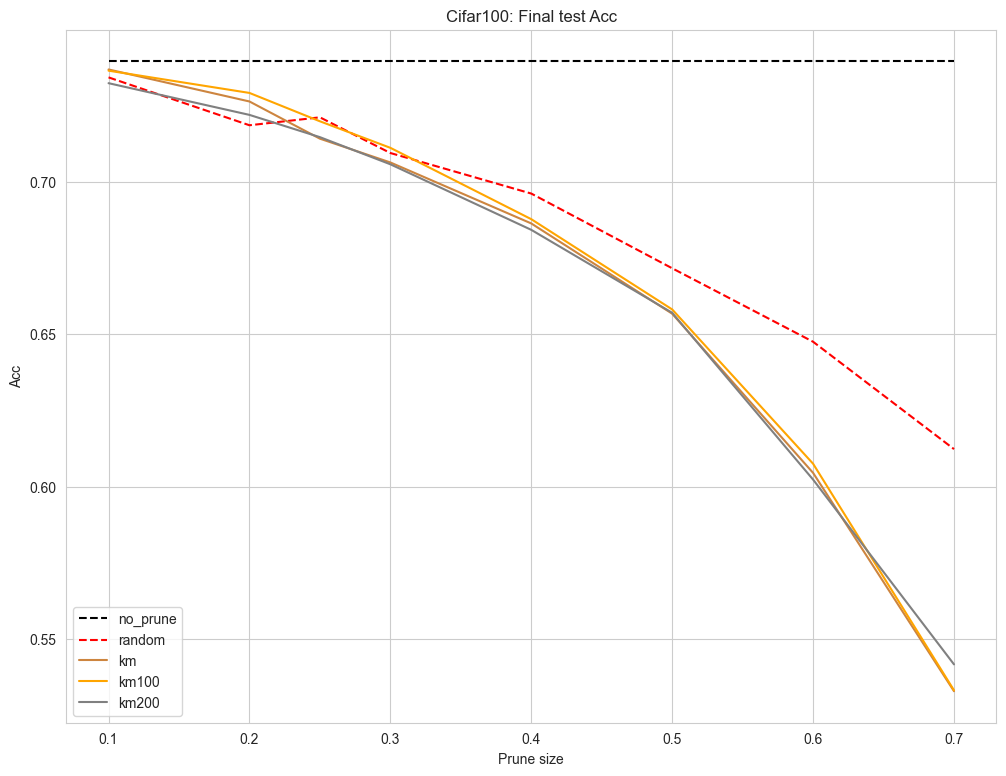

In [7]:
plt.figure(figsize=(12, 9))
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple', 'peru', 'orange', 'gray')
#          no       rand    el2n     std     sum     flip      forget   km      km100    km200

markers = ('dashed', 'solid')
for i, prune_method in enumerate(acc_test):
    if prune_method in ['km', 'km100', 'km200', 'no_prune', 'random']:
        plt.plot(prune_sizes, [acc_test[prune_method][p] for p in prune_sizes], label=prune_method,
                 c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower left')
plt.grid(True)
plt.xlabel('Prune size')
plt.ylabel('Acc')
plt.title('Cifar100: Final test Acc')
plt.show()

In [5]:
import pickle

with open(os.path.join(DIR_ROOT_SAVE, 'cifar100_10_70_graph'), 'wb') as f:
    pickle.dump(acc_test, f)

In [ ]:
[x for acc_test]